In [ ]:
pip install graphlime

  Preparing metadata (setup.py) ... done
  Created wheel for graphlime: filename=graphlime-1.2.0-py3-none-any.whl size=2596 sha256=af6a3fe136cfd1be99cdc0ce88784ee1d7a26f79203628bdd3b579a6109659e4
  Stored in directory: /root/.cache/pip/wheels/7b/18/fd/db68e85d0bc6d250555f50b9774635ec3dbea4eea2c31282a4
Successfully built graphlime


In [ ]:
pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import networkx as nx
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch_geometric.nn import GATConv
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

from graphlime import GraphLIME

import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
dataset = Planetoid('.', 'Cora', transform=NormalizeFeatures())
data = dataset[0]
data

Processing...
Done!


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

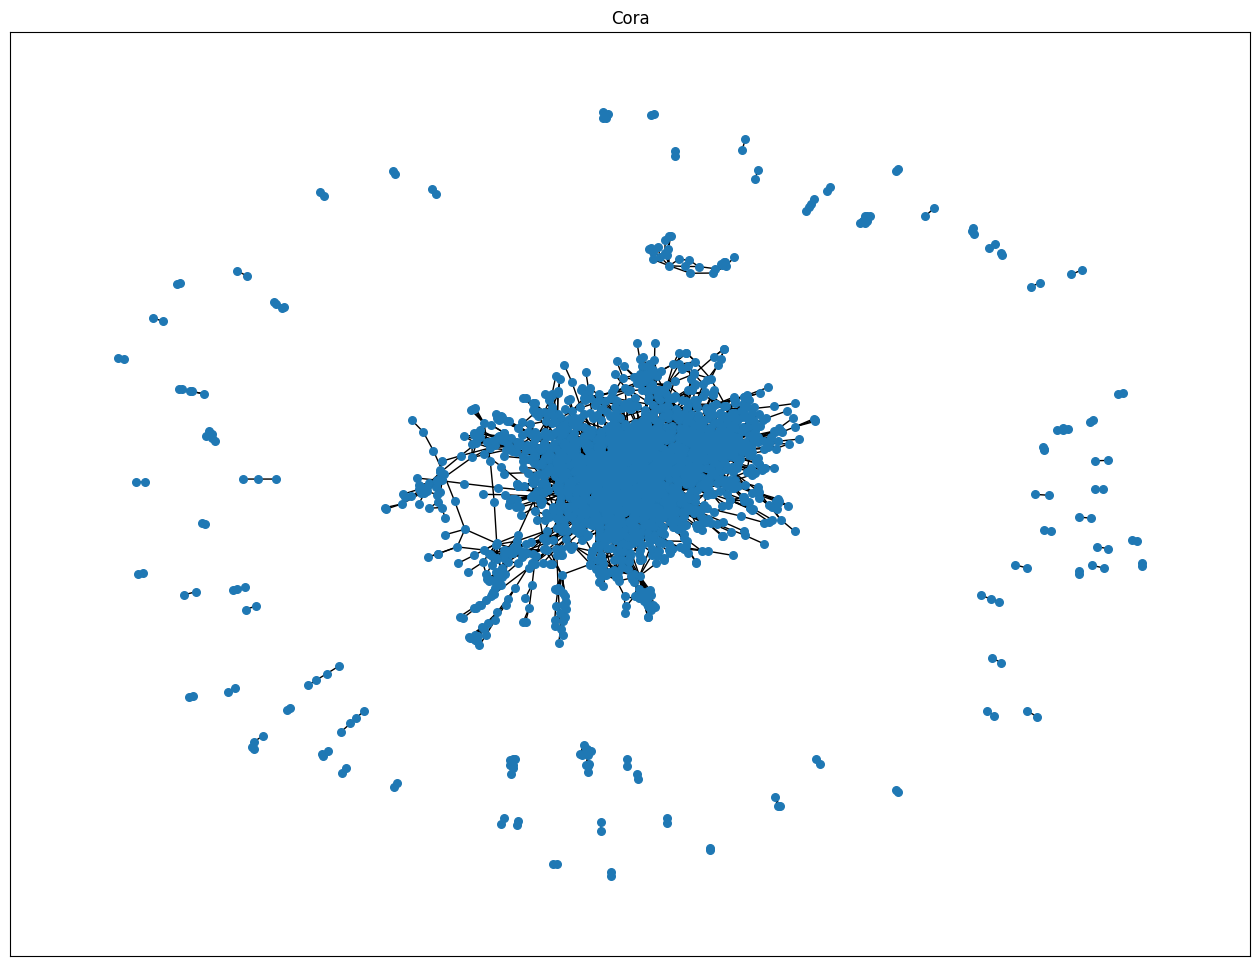

In [ ]:
plt.figure(figsize=(16, 12))

G = to_networkx(data, to_undirected=True)
pos = nx.spring_layout(G, k=0.1)
nx.draw_networkx(G, with_labels=False, node_size=30)

plt.title('Cora');

In [ ]:
degrees = dict(nx.degree(G))
node_indices = list(degrees.keys())
node_degrees = list(degrees.values())

max_degree = max(node_degrees)
node_idx = np.argmax(node_degrees).item()

Node 1358 has the largest degree value 168.


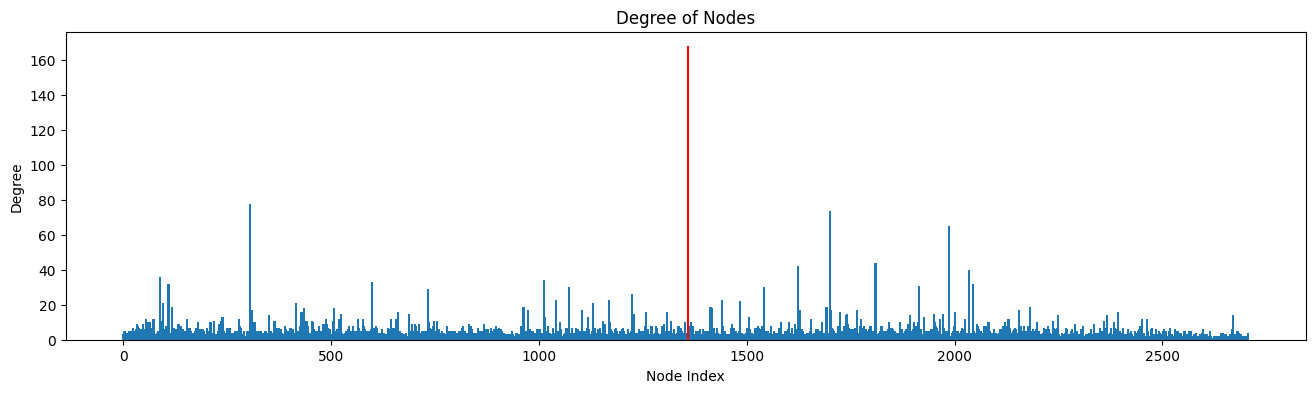

In [ ]:
plt.figure(figsize=(16, 4))

plt.bar(node_indices, node_degrees, width=5.0)

plt.vlines(x=node_idx, ymin=0, ymax=max_degree, colors='r')

plt.title('Degree of Nodes')
plt.xlabel('Node Index')
plt.ylabel('Degree');

print(f'Node {node_idx} has the largest degree value {max_degree}.')

In [ ]:
class GAT(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim,
                 heads_1=8, heads_2=1, att_dropout=0.6, input_dropout=0.6):

        super(GAT, self).__init__()

        self.att_dropout = att_dropout
        self.input_dropout = input_dropout

        self.conv1 = GATConv(in_channels=input_dim,
                             out_channels=hidden_dim // heads_1,
                             heads=heads_1,
                             concat=True,
                             dropout=att_dropout)
        self.conv2 = GATConv(in_channels=hidden_dim,
                             out_channels=output_dim,
                             heads=heads_2,
                             concat=False,
                             dropout=att_dropout)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.input_dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.input_dropout, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [ ]:
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super(GCN, self).__init__()

        self.dropout = dropout

        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super(GraphSAGE, self).__init__()

        self.dropout = dropout

        self.conv1 = SAGEConv(in_channels=input_dim, out_channels=hidden_dim)
        self.conv2 = SAGEConv(in_channels=hidden_dim, out_channels=output_dim)

    def forward(self, x, edge_index):
        # First GraphSAGE layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Second GraphSAGE layer
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)


In [ ]:
hparams = {
    'input_dim': data.num_node_features,
    'hidden_dim': 16,
    'output_dim': max(data.y).item() + 1
}

model = GraphSAGE(**hparams)
model

GraphSAGE(
  (conv1): SAGEConv(1433, 16, aggr=mean)
  (conv2): SAGEConv(16, 7, aggr=mean)
)

In [ ]:
def accuracy(output, labels):
    _, pred = output.max(dim=1)
    correct = pred.eq(labels).double()
    correct = correct.sum()

    return correct / len(labels)

In [ ]:
lr = 0.005
epochs = 400

model.train()
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()

    output = model(data.x, data.edge_index)
    loss = F.nll_loss(output[data.train_mask], data.y[data.train_mask])

    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        acc = accuracy(output[data.train_mask], data.y[data.train_mask])
        print('Epoch: {:3d}, acc = {:.3f}'.format(epoch, acc))

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch:   0, acc = 0.143
Epoch:  10, acc = 0.586
Epoch:  20, acc = 0.729
Epoch:  30, acc = 0.800
Epoch:  40, acc = 0.843
Epoch:  50, acc = 0.914
Epoch:  60, acc = 0.957
Epoch:  70, acc = 0.936
Epoch:  80, acc = 0.957
Epoch:  90, acc = 0.986
Epoch: 100, acc = 0.957
Epoch: 110, acc = 0.979
Epoch: 120, acc = 1.000
Epoch: 130, acc = 0.986
Epoch: 140, acc = 0.986
Epoch: 150, acc = 1.000
Epoch: 160, acc = 0.993
Epoch: 170, acc = 0.993
Epoch: 180, acc = 0.993
Epoch: 190, acc = 1.000
Epoch: 200, acc = 0.993
Epoch: 210, acc = 1.000
Epoch: 220, acc = 0.986
Epoch: 230, acc = 1.000
Epoch: 240, acc = 1.000
Epoch: 250, acc = 0.993
Epoch: 260, acc = 1.000
Epoch: 270, acc = 0.986
Epoch: 280, acc = 0.986
Epoch: 290, acc = 0.986
Epoch: 300, acc = 0.979
Epoch: 310, acc = 1.000
Epoch: 320, acc = 0.993
Epoch: 330, acc = 0.993
Epoch: 340, acc = 0.993
Epoch: 350, acc = 0.993
Epoch: 360, acc = 1.000
Epoch: 370, acc = 1.000
Epoch: 380, acc = 1.000
Epoch: 390, acc = 0.993


In [ ]:
node_idx

1358

In [ ]:
model.eval()

GraphSAGE(
  (conv1): SAGEConv(1433, 16, aggr=mean)
  (conv2): SAGEConv(16, 7, aggr=mean)
)

In [ ]:
import sklearn

In [ ]:
print(sklearn.__version__)

1.5.2


In [ ]:
import numpy as np
from sklearn.linear_model import LassoLars
import torch
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import k_hop_subgraph

class GraphLIME:
    def __init__(self, model, hop=2, rho=0.1, cached=True):
        self.hop = hop
        self.rho = rho
        self.model = model
        self.cached = cached
        self.cached_result = None
        self.model.eval()
    def __flow__(self):
        for module in self.model.modules():
            if isinstance(module, MessagePassing):
                return module.flow
        return 'source_to_target'

    def __subgraph__(self, node_idx, x, y, edge_index, **kwargs):
        num_nodes, num_edges = x.size(0), edge_index.size(1)

        subset, edge_index, mapping, edge_mask = k_hop_subgraph(
            node_idx, self.hop, edge_index, relabel_nodes=True,
            num_nodes=num_nodes, flow=self.__flow__())

        x = x[subset]
        y = y[subset]

        for key, item in kwargs.items():
            if torch.is_tensor(item) and item.size(0) == num_nodes:
                item = item[subset]
            elif torch.is_tensor(item) and item.size(0) == num_edges:
                item = item[edge_mask]
            kwargs[key] = item
        return x, y, edge_index, mapping, edge_mask, kwargs

    def __init_predict__(self, x, edge_index, **kwargs):
        if self.cached and self.cached_result is not None:
            if x.size(0) != self.cached_result.size(0):
                raise RuntimeError(
                    'Cached {} number of nodes, but found {}.'.format(
                        x.size(0), self.cached_result.size(0)))
        
        if not self.cached or self.cached_result is None:
            with torch.no_grad():
                log_logits = self.model(x=x, edge_index=edge_index, **kwargs)
                probas = log_logits.exp()

            self.cached_result = probas

        return self.cached_result

    def __compute_kernel__(self, x, reduce):
        assert x.ndim == 2, x.shape

        n, d = x.shape

        dist = x.reshape(1, n, d) - x.reshape(n, 1, d)  # (n, n, d)
        dist = dist ** 2

        if reduce:
            dist = np.sum(dist, axis=-1, keepdims=True)  # (n, n, 1)

        std = np.sqrt(d)

        K = np.exp(-dist / (2 * std ** 2 * 0.1 + 1e-10))  # (n, n, 1) or (n, n, d)

        return K

    def __compute_gram_matrix__(self, x):
        # unstable implementation due to matrix product (HxH)
        # n = x.shape[0]
        # H = np.eye(n, dtype=np.float) - 1.0 / n * np.ones(n, dtype=np.float)
        # G = np.dot(np.dot(H, x), H)

        # more stable and accurate implementation
        G = x - np.mean(x, axis=0, keepdims=True)
        G = G - np.mean(G, axis=1, keepdims=True)

        G = G / (np.linalg.norm(G, ord='fro', axis=(0, 1), keepdims=True) + 1e-10)

        return G

    def explain_node(self, node_idx, x, edge_index, **kwargs):
        probas = self.__init_predict__(x, edge_index, **kwargs)

        x, probas, _, _, _, _ = self.__subgraph__(
            node_idx, x, probas, edge_index, **kwargs)

        x = x.detach().cpu().numpy()  # (n, d)
        y = probas.detach().cpu().numpy()  # (n, classes)

        n, d = x.shape

        K = self.__compute_kernel__(x, reduce=False)  # (n, n, d)
        L = self.__compute_kernel__(y, reduce=True)  # (n, n, 1)

        K_bar = self.__compute_gram_matrix__(K)  # (n, n, d)
        L_bar = self.__compute_gram_matrix__(L)  # (n, n, 1)

        K_bar = K_bar.reshape(n ** 2, d)  # (n ** 2, d)
        L_bar = L_bar.reshape(n ** 2,)  # (n ** 2,)

        #solver = LassoLars(self.rho, fit_intercept=False, normalize=False, positive=True)
        solver = LassoLars(self.rho, fit_intercept=False, positive=True)

        solver.fit(K_bar * n, L_bar * n)
        return solver.coef_

In [ ]:
import copy
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import Ridge

import torch


class LIME:

    def __init__(self, model, num_samples, cached=True):
        self.model = model
        self.num_samples = num_samples
        self.cached = cached
        self.cached_result = None

        self.model.eval()

    def __init_predict__(self, x, edge_index, **kwargs):
        if self.cached and self.cached_result is not None:
            if x.size(0) != self.cached_result.size(0):
                raise RuntimeError(
                    'Cached {} number of nodes, but found {}.'.format(
                        x.size(0), self.cached_result.size(0)))

        if not self.cached or self.cached_result is None:
            
            with torch.no_grad():
                log_logits = self.model(x=x, edge_index=edge_index, **kwargs)
                probas = log_logits.exp()

            self.cached_result = probas

        return self.cached_result

    def explain_node(self, node_idx, x, edge_index, **kwargs):
        probas = self.__init_predict__(x, edge_index, **kwargs)
        proba, label = probas[node_idx, :].max(dim=0)

        x_ = copy.deepcopy(x)
        original_feats = x[node_idx, :]

        sample_x = [original_feats.detach().cpu().numpy()]
        sample_y = [proba.item()]

        for _ in tqdm(range(self.num_samples), desc='collect samples', leave=False):
            x_[node_idx, :] = original_feats + torch.randn_like(original_feats)

            with torch.no_grad():
                log_logits = self.model(x=x_, edge_index=edge_index, **kwargs)
                probas_ = log_logits.exp()

            proba_ = probas_[node_idx, label]

            sample_x.append(x_[node_idx, :].detach().cpu().numpy())
            sample_y.append(proba_.item())

        sample_x = np.array(sample_x)
        sample_y = np.array(sample_y)

        solver = Ridge(alpha=0.1)
        solver.fit(sample_x, sample_y)

        return solver.coef_


class Greedy:

    def __init__(self, model, cached=True):
        self.model = model
        self.cached = cached
        self.cached_result = None

        self.model.eval()

    def __init_predict__(self, x, edge_index, **kwargs):
        if self.cached and self.cached_result is not None:
            if x.size(0) != self.cached_result.size(0):
                raise RuntimeError(
                    'Cached {} number of nodes, but found {}.'.format(
                        x.size(0), self.cached_result.size(0)))

        if not self.cached or self.cached_result is None:
            # get the initial prediction
            with torch.no_grad():
                log_logits = self.model(x=x, edge_index=edge_index, **kwargs)
                probas = log_logits.exp()

            self.cached_result = probas

        return self.cached_result

    def explain_node(self, node_idices, x, edge_index, **kwargs):
        if isinstance(node_idices, int):
            node_idices = [node_idices]

        probas = self.__init_predict__(x, edge_index, **kwargs)
        probas, labels = probas[node_idices, :].max(dim=1)  # (m,), (m,)

        num_nodes, num_feats = len(node_idices), x.size(1)
        delta_probas = np.zeros((num_nodes, num_feats))  # (m, #feats)

        self.model.eval()

        for feat_idx in tqdm(range(num_feats), desc='search features', leave=False):
            x_ = copy.deepcopy(x)
            x_[:, feat_idx] = 0.0

            with torch.no_grad():
                log_logits = self.model(x=x_, edge_index=edge_index, **kwargs)
                probas_ = log_logits.exp()

            probas_ = probas_[node_idices, :]  # (m, #classes)

            for node_idx in range(num_nodes):
                proba = probas[node_idx].item()
                label = labels[node_idx]
                proba_ = probas_[node_idx, label].item()

                delta_probas[node_idx, feat_idx] = abs((proba - proba_) / proba)

        return delta_probas


class Random:

    def __init__(self, num_feats, K):
        self.num_feats = num_feats
        self.K = K

    def explain_node(self):
        return np.random.choice(self.num_feats, self.K)

In [ ]:
print(sklearn.__version__)

1.5.2


In [ ]:
pip install --upgrade graphlime

In [ ]:

explainer = GraphLIME(model, hop=2, rho=0.1, cached=True)

coefs = explainer.explain_node(node_idx, data.x, data.edge_index)
coefs

# Instantiate a LIME explainer
#explainer = LIME(model=model, num_samples=1000, cached=True)  # Adjust `num_samples` as needed

# Explain node features by calling the `explain_node` method
#coefs = explainer.explain_node(node_idx=node_idx, x=data.x, edge_index=data.edge_index)
#
# Print the coefficients for the explanation
#print(coefs)


array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

The 1263-th feature is the most important.


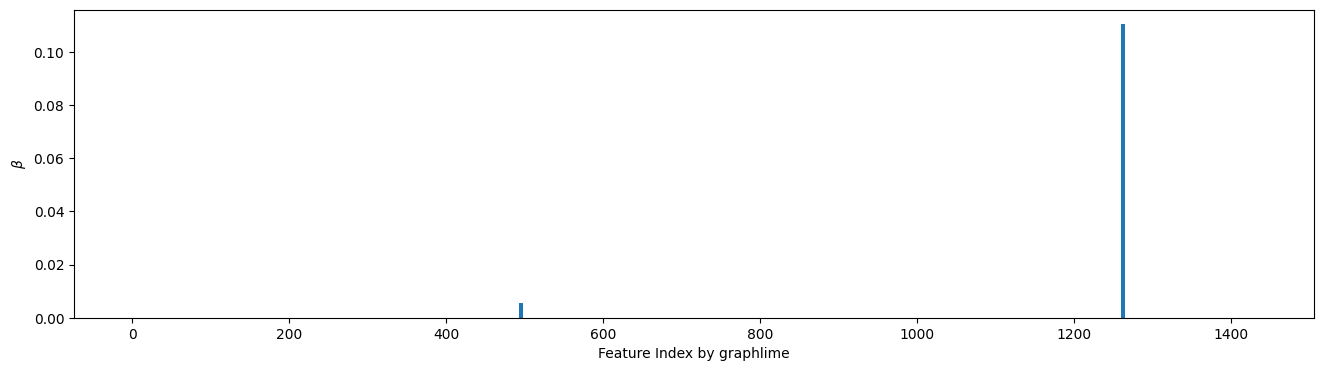

In [ ]:
plt.figure(figsize=(16, 4))

x = list(range(data.num_node_features))

plt.bar(x, coefs, width=5.0)
plt.xlabel('Feature Index by graphlime')
plt.ylabel(r'$\beta$');

print(f'The {np.argmax(coefs)}-th feature is the most important.')